In [1]:
from IPython.core.display import HTML
HTML("""
<style>
font-family: monospace;
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    background-color: AliceBlue;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h2 {
    text-align: center;
    background-color: HoneyDew;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h3 {
    text-align: center;
    background-color: MintCream;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}


body, p {
    font-family: monospace;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: monospace;
    color: purple;
}
</style>
""")



# Use multiple GPU's with Tensorflow / Keras on Kaggle. 
Recently, **Kaggle has introduced the possibility of using two GPUs in our notebooks.** We are going to see how to use them in a simple way with TensorFlow. 


The technique of using more than one GPU on a single machine is called MirroredStrategy. It is the one we are going to use in Kaggle. Or on our machine if we had more than one GPU.

Just be sure that you have multiple GPU's selected in the Settings Section of the notebook.

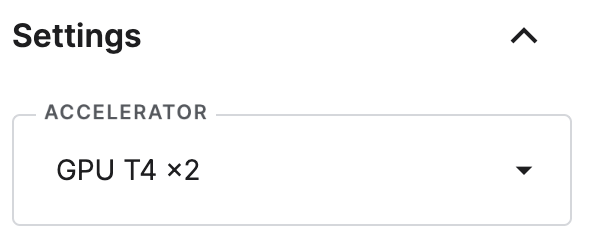

In [2]:
import tensorflow as tf
import time
import tensorflow_datasets as tfds
import tensorflow_hub as hub

## Different strategies

There are different multi-GPU execution strategies that we can use depending on the type of environment in which we execute the model:

* MirroredStrategy: Multiple GPUs in a machine, and variables mirrored in each GPU. 
* CentralStorageStrategy. Multiple GPUs in a machine, but the variables are stored and treated in the CPU. *tf.distribute.experimental.CentralStorageStrategy*
* MultiMowrkerMirroredStrategy. Multiple machines. 

In Kaggle, we can use MirroredStrategy and CentralStorageStrategy. The first is more efficient, while the second consumes less memory, but this latter is still labelled as 'experimental' so I recommend always using MirroredStrategy.


In [3]:
# Define tand get the number os devices. 
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

2022-12-06 07:49:46.938000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 07:49:46.938942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 07:49:47.063710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 07:49:47.064571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 07:49:47.065378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

DEVICES AVAILABLE: 2


## Import & data
I retrieved the data from a TensorFlow dataset instead of Kaggle to make it easier to run the notebook in other environments and make it easier to test, in our local machines. 

In [4]:
#Choose the Dataset you want to use. 
#In Kaggle I do not recommend cats_vs_dogs 
#because we can reach the limit of memory consumption.

#setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
#TS_2_DOWNLOAD = 'cats_vs_dogs'

TS_2_DOWNLOAD = 'horses_or_humans'

splits, info_cd = tfds.load(TS_2_DOWNLOAD, 
                         as_supervised=True, 
                         with_info=True, 
                         split=['train[:70%]', 'train[70%:]'], 
                         data_dir='./data')

2022-12-06 07:49:51.140777: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling horses_or_humans-train.tfrecord...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling horses_or_humans-test.tfrecord...:   0%|          | 0/256 [00:00<?, ? examples/s]

Dataset horses_or_humans downloaded and prepared to ./data/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [5]:
num_examples_cd = info_cd.splits['train'].num_examples
num_classes_cd = info_cd.features['label'].num_classes

(train_examples, validation_examples) = splits
num_examples = num_examples_cd
num_classes = num_classes_cd

In [6]:
IMAGE_SIZE = 224

BUFFER_SIZE = 10000
BATCH_SIZE_PER_REPLICA = 64

#We obtain the BATCH_SIZE dividing by the number of devices. 
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [7]:
#Treat the image 
def map_fn(img, label):
    # resize the image
    img = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])
    # normalize the image
    img /= 255.0
    return img, label

In [8]:
# Prepare train dataset by using preprocessing with map_fn, shuffling and batching
def prepare_dataset(train_examples, validation_examples, num_examples, map_fn, batch_size):
    train_ds = train_examples.map(map_fn).shuffle(buffer_size = num_examples).batch(batch_size)
    valid_ds = validation_examples.map(map_fn).batch(batch_size)
    
    return train_ds, valid_ds

In [9]:
train_ds, valid_ds = prepare_dataset(train_examples, 
                                                validation_examples, 
                                                num_examples, 
                                                map_fn, BATCH_SIZE)

# Executing the model in multiple GPUs

You have two models to use, both from TensorFlow HUB. I recommend using the smaller model. But if you want to try a heavier model, just uncomment the line that loads the *resnet_v2_152 model*.

When defining the model we do it within the scope that we have created at the beginning in the *strategy* variable. 

In [10]:
MODULE_HANDLE = 'https://tfhub.dev/tensorflow/resnet_50/feature_vector/1'
#MODULE_HANDLE = 'https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5'

with strategy.scope():
    model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,565,250
Trainable params: 4,098
Non-trainable params: 23,561,152
_________________________________________________________________


In [11]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [12]:
start_time=time.time()
model.fit(train_ds, epochs=20, validation_data=valid_ds, verbose=2)
end_time=time.time()

2022-12-06 07:50:06.224826: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:461] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.
2022-12-06 07:50:06.355243: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

6/6 - 31s - loss: 0.4317 - accuracy: 0.7955 - val_loss: 0.0994 - val_accuracy: 1.0000
Epoch 2/20
6/6 - 3s - loss: 0.0500 - accuracy: 1.0000 - val_loss: 0.0199 - val_accuracy: 1.0000
Epoch 3/20
6/6 - 3s - loss: 0.0142 - accuracy: 0.9986 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 4/20
6/6 - 3s - loss: 0.0077 - accuracy: 0.9986 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 5/20
6/6 - 3s - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 6/20
6/6 - 3s - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 7/20
6/6 - 3s - loss: 0.0034 - accuracy: 0.9986 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 8/20
6/6 - 3s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 9/20
6/6 - 3s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 10/20
6/6 - 3s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 11/20
6/6 - 3s - loss: 0.0022 - accuracy: 1

In [13]:
print(end_time-start_time)

84.4666850566864


The model spent 95 seconds to execute in multiple GPUs. 

# Executing the model in Single GPU
I'm preparing a new dataset with the correct BATCH_SIZE, and define the same model but without the *with_strategy scope*. 

In [14]:
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * 1

train_ds_eager, valid_ds_eager = prepare_dataset(train_examples, 
                                                        validation_examples, 
                                                        num_examples, 
                                                        map_fn, BATCH_SIZE)
model2 = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23561152  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,565,250
Trainable params: 4,098
Non-trainable params: 23,561,152
_________________________________________________________________


In [15]:
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [16]:
start_time=time.time()
model2.fit(train_ds_eager, epochs=20, validation_data=valid_ds_eager, verbose=2)
end_time=time.time()

Epoch 1/20
12/12 - 10s - loss: 0.2979 - accuracy: 0.8707 - val_loss: 0.0484 - val_accuracy: 1.0000
Epoch 2/20
12/12 - 4s - loss: 0.0232 - accuracy: 0.9986 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 3/20
12/12 - 4s - loss: 0.0099 - accuracy: 0.9986 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 4/20
12/12 - 4s - loss: 0.0060 - accuracy: 0.9986 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 5/20
12/12 - 4s - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 6/20
12/12 - 4s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 7/20
12/12 - 4s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 8/20
12/12 - 4s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 9/20
12/12 - 4s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 10/20
12/12 - 4s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 11/20
12/12 

In [17]:
print(end_time-start_time)

97.93506574630737


This execution on a single GPU takes 97 seconds. About 10 more than that done on multiple GPUs.
# Conclusions, Fork & More. 
Thank you very much, Kaggle, for allowin8g us to use multiple GPUs. Not only because of the improvement that we can obtain in performance during the execution of our models, but also because of the possibility of testing these techniques in an environment as affordable as Kaggle's.

Using multiple GPUs is so easy that there really is no reason not to do it now that we can. The advantage obtained will be greater or less depending on our Dataset and model. But we can always test and decide if we want to use multiple GPUs or just one.

If you want you can fork the notebook and try different models, and datasets, even you can try CentralStorageStrategy. 


#### **Please, if you liked the notebook, consider upvoting it. It really encourages me a lot to write more notebooks like that.**
